# A Julia implementation of Reiter (2009)

## A small model

The considered model is an extension of Aiyagari (1994) with the mere addition of an aggregate productivity shock. It can be summed up as follows

Each household $i$ solves :
$$
\max_{c_{i,t}, k_{i,t+1}} \mathbb{E}_0 \sum_{t=0}^{\infty} \beta^t u (c_t)\\
\text{s.t.}
\begin{cases}
c_{i,t} + k_{i,t+1} = (1+r_t) k_{i,t} + \xi_{i,t} w_t\\
a_{i,t+1} \geq 0
\end{cases}
$$
where $\xi_{i,t}$ is an i.i.d idiosyncratic labor productivity shock such that $\mathbb{E} \xi_{i,t} = 1$. It follows a log-Normal law in our case.

Firms are competitive and operate a Cobb-Douglas technology with labor and capital as inputs. Capital depreciates at rate $\delta$. The FOC of the representative firm's program lead to
$$
r_t = \alpha z_t \left( \frac{K_t}{N} \right)^{\alpha-1} - \delta\\
w_t = (1-\alpha) z_t \left( \frac{K_t}{N} \right)^{\alpha}
$$

The market clearing condition on capital implies that
$$
K_t = \int k_{i,t} di
$$

Finally, aggregate productivity shocks follow
$$
log \left( z_t \right) = \rho_z log \left( z_{t-1} \right) + \epsilon_t, \epsilon_t \sim \mathcal{N} \left( 0, \sigma_z^2 \right)
$$

## Let's solve it!

Reiter (2009) solves the model in 3 steps
   1. discretize the model
   2. find the steady state of the discretized model without aggregate shocks
   3. compute a first-order perturbation of the discretized model around its steady state

### 1. Discretizing the model

The model is discretized in several regards:
   - integrals involving idiosyncratic shocks are approached using Gauss-Hermite nodes $\xi$ and $\omega$. The `gaussHermite` routine takes care of this
   - households' decision rule is approached using linear interpolation over a grid of earnings `x` with `n_p+1` points. The minimal value of the earnings grid $\chi$ is such that the liquidity constraint is binding 
   - the capital distribution is approached using an histogram, with capital grid `k` and `n_d+1` knot points
The latter elements are stored in `DiscretizedModel` structures. In the code, I denote `s` the value the households' decision rule takes at knot points `x` and `p` the histogram.

I also define the `Parameters`, `Prices` and `Aggregates` structures to store relevant parameters, prices (e.g. $r_t$, $w_t$) and aggregate endogenous and exogenous variables (e.g.  $A_t$, $z_t$)

### 2. Finding the steady-state

The agorithm to find the steady state without aggregate shocks is the following
   1. Provide an initial guess for aggregate capital: in my case, it implies updating the `Aggregates` structure with the proper values
   2. Compute the prices stemming from the value of aggregate capital. The `setPrices!` routine update the `Prices` structure accordingly.
   3. Compute the associated households' decision rule: I use the endogenous grid method Carroll (2006) makes a case for in the `decisionRule!` function
   4. Get the associated distribution of capital. The `setTransition` routine derives the Markov transition matrix $\Pi$. It is possible to get the ergodic distribution of capital $p$ using a simple linear algebra trick. There is an infinity of solutions to the equation $p = p \Pi$, and we need to select the solution such that $\sum p_i = 1$. A way to introduce the latter constraint and still solve for $p = p \Pi$ is to solve the linear equation
   
$$
p \begin{pmatrix}
\pi_{11}-1 & \cdots & \pi_{1,n-1} & 1\\
\vdots & \ddots & \vdots & \vdots\\
\pi_{n1} & \cdots & \pi_{1,n-1}-1 & 1
\end{pmatrix} = \begin{pmatrix} 0 & \cdots & 0 & 1\end{pmatrix}
$$

   5. Compute the capital supply associated with the discretized distribution `p`. The `capitalSupply` routine carries out the calculation. `excessCapital` returns the difference between the capital guess and the capital supply
   
The steady-state aggregate capital is a zero of the `excessCapital` function. 
   
### 3. Carrying out first-order perturbation

The function `H` returns the system of equilibrium equations

$$
H(x_t, x_{t+1}, y_t, y_{t+1}) = \begin{cases}
u' (c_t) - \beta \mathbb{E}_t \Bigg( R_{t+1} u' (c_{t+1}) \Bigg)\\
p_{t+1} - p_t \Pi_t\\
K_{t+1} - \Bigg( k_{0} p_0 + \sum_{i=1}^{n_d} \frac{1}{2} p_i (k_i + k_{i-1}) \Bigg)\\
log( z_{t+1} ) - \rho_z log ( z_t )
\end{cases}
$$

The state variables are $x_t = (p_t, K_t, z_t)$ and the control variables are $y_t = s_t$. It is then possible to solve the model using the first-order derivatives of $H$ with respect to $x_t$, $x_{t+1}$, $y_t$ and $y_{t+1}$ along the method SGU (2004) presents. The `solve_eig` routine carries it out.

In [1]:
using Roots
using LinearAlgebra
using SparseArrays
import FiniteDiff.finite_difference_jacobian
using Plots
pyplot()

using ReiterJulia

┌ Info: Precompiling FiniteDiff [6a86dc24-6348-571c-b903-95158fe2bd41]
└ @ Base loading.jl:1278
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278
ERROR: LoadError: ArgumentError: Package Zlib_jll does not have JLLWrappers in its dependencies:
- If you have Zlib_jll checked out for development and have
  added JLLWrappers as a dependency but haven't updated your primary
  environment's manifest file, try `Pkg.resolve()`.
- Otherwise you may need to report an issue with Zlib_jll
Stacktrace:
 [1] require(::Module, ::Symbol) at ./loading.jl:906
 [2] include(::Function, ::Module, ::String) at ./Base.jl:380
 [3] include(::Module, ::String) at ./Base.jl:368
 [4] top-level scope at none:2
 [5] eval at ./boot.jl:331 [inlined]
 [6] eval(::Expr) at ./client.jl:467
 [7] top-level scope at ./none:3
in expression starting at /home/normann/.julia/packages/Zlib_jll/BGVLi/src/Zlib_jll.jl:5
ERROR: LoadError: LoadError: Failed to precompile Zlib_jll [83775a58-1f1d

LoadError: [91mFailed to precompile Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] to /home/normann/.julia/compiled/v1.5/Plots/ld3vC_Fnq48.ji.[39m

In [6]:
n_p = 100
n_d = 200
n_ξ = 41

d = DiscretizedModel()
params = Parameters()
initParameters!(params)
P = Prices()
A = Aggregates()
z = 0.
@save A z

0.0

In [7]:
initDiscretizedModel!(d, n_p, n_d, n_ξ, params) # initializes the DiscretizedModel structure
s = 0.8*d.x  # houdeholds' policy function for capital taken at points in the earnings grid x

101-element Array{Float64,1}:
 0.0
 0.014463262250645849
 0.02918800694495545
 0.04417896144437439
 0.05944093857668414
 0.07497883818115395
 0.09079764868162812
 0.10690244868805454
 0.12329840862696476
 0.1399907924014345
 0.15698495908105237
 0.1742863646224434
 0.19190056362089686
 ⋮
 3.141346342754249
 3.212602249974097
 3.285146398285231
 3.359002077898581
 3.434193000090616
 3.510743304815815
 3.5886775684567747
 3.6680208117144204
 3.748798507640882
 3.831036589817577
 3.914761460681163
 4.0

In [8]:
Kss = find_zero(x->excessCapital!(d, A, P, params, s, x, verbose=false), (0.95, 1.05), verbose=true, xatol = eps())
A.K = Kss

Π = setTransition!(d, P, params, s)
M = Π - I(d.n_d+1)
M[:,end] .= 1
b = zeros(d.n_d+1)
b[end] = 1
p = M'\b

println("Check steady-state residual: ", A.K - capitalSupply(p,d))

i = 593: 2.220446049250313e-16
i = 2001: 4.440892098500626e-16
i = 555: 2.220446049250313e-16
i = 510: 1.1102230246251565e-16
i = 540: 2.220446049250313e-16
i = 524: 2.220446049250313e-16
i = 2001: 4.440892098500626e-16
i = 504: 2.220446049250313e-16
i = 488: 2.220446049250313e-16
i = 481: 2.220446049250313e-16
i = 471: 2.220446049250313e-16
i = 450: 1.1102230246251565e-16
i = 443: 2.220446049250313e-16
i = 427: 2.220446049250313e-16
i = 413: 2.220446049250313e-16
i = 403: 2.220446049250313e-16
i = 389: 2.220446049250313e-16
i = 387: 2.220446049250313e-16
i = 370: 2.220446049250313e-16
i = 355: 2.220446049250313e-16
i = 2001: 4.440892098500626e-16
i = 340: 5.551115123125783e-17
i = 323: 5.551115123125783e-17
i = 306: 2.220446049250313e-16
i = 300: 2.220446049250313e-16
i = 279: 2.220446049250313e-16
i = 270: 2.220446049250313e-16
i = 252: 2.220446049250313e-16
i = 239: 2.220446049250313e-16
i = 223: 2.220446049250313e-16
i = 226: 1.1102230246251565e-16
i = 197: 2.220446049250313e-16
i 

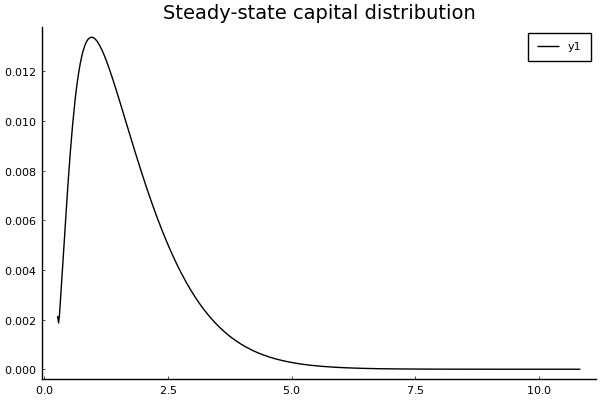

In [9]:
plot(d.x_fine, p, color="black", title = "Steady-state capital distribution")
xgrid!(:off)
ygrid!(:off)

In [10]:
x = vcat(p[2:end], [A.K, A.z])
y = s
H_x = finite_difference_jacobian(u->H(u,x,y,y,d,params), x)
H_xp = finite_difference_jacobian(u->H(x,u,y,y,d,params), x)
H_y = finite_difference_jacobian(u->H(x,x,u,y,d,params), y)
H_yp = finite_difference_jacobian(u->H(x,x,y,u,d,params), y)

303×101 Array{Float64,2}:
  0.0           0.0          0.0         …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 -0.01966       0.361534    -0.131616       0.0  0.0  0.0  0.0  0.0  0.0  0.0
 -0.0880118    -0.111547     0.271743       0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0          -0.11411     -0.123926       0.0  0.0  0.0  0.0  0.0  0.0  0.0
 -0.0139637    -0.0649721   -0.126716       0.0  0.0  0.0  0.0  0.0  0.0  0.0
 -0.011585     -0.0434159   -0.071323    …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 -0.00419577   -0.0205182   -0.0456862      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 -0.000775784  -0.00654915  -0.0207606      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 -9.72115e-5   -0.0013286   -0.00637946     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 -4.50015e-6   -7.62045e-5  -0.00121228     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 -2.6077e-8    -4.36977e-6  -6.85304e-5  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0          -2.23517e-8  -3.23355e-6     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0           0.0         -1.11759e-

In [11]:
AA = hcat(H_xp, H_yp)
BB = -hcat(H_x, H_y)
# g_x is the jacobian of the decision function (controls) wrt states
# h_x is the jacobian of the transition function (states) wrt states 
g_x, h_x, eu = solve_eig(AA, BB, d.n_d+2)

([0.0 0.0 … 0.0 0.0; -0.00026313522898009173 -0.0008337820176205943 … 0.00010029855313650575 -0.11797057198517251; … ; -0.0003324808869738197 -0.001060664055651425 … 0.0005927951016335622 -0.12891285737927835; -0.00033248273435917557 -0.0010606699534934554 … 0.0005927990810667513 -0.12891451782930233], [-0.004348347716884213 -0.01753639379026771 … -0.003150794536437837 0.007686842551447581; 0.0007409612465928955 -0.0015155705075929511 … -0.0029979167746820856 -0.004846306914827958; … ; 0.0031994293491060663 0.010114375611781757 … -0.0004564384575374506 0.3077460197761397; 0.0 0.0 … 0.0 0.8], Bool[1, 1])

Impulse response functions after an aggregate productivity shock of +0.1

In [14]:
T = 60
dx = zeros(n_d+2,T)
dx[end,1] = 0.1
for t in 2:T
    dx[:,t] .= h_x*dx[:,t-1]
end

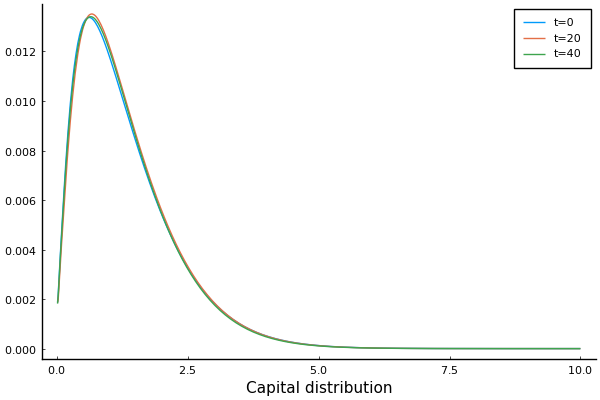

In [15]:
plot(d.k[2:end], dx[1:n_d,1]+x[1:n_d], label="t=0")
plot!(d.k[2:end], dx[1:n_d,20]+x[1:n_d], label="t=20")
plot!(d.k[2:end], dx[1:n_d,40]+x[1:n_d], label="t=40")
xgrid!(:off)
ygrid!(:off)
xlabel!("Capital distribution")

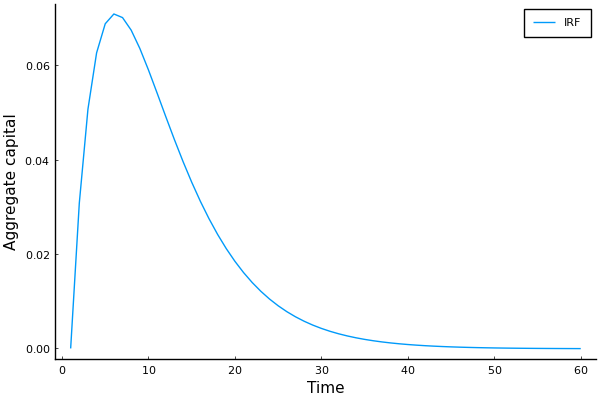

In [18]:
plot(1:T, x[end] .+ dx[end-1,:], label="IRF")
xlabel!("Time")
ylabel!("Aggregate capital")
xgrid!(:off)
ygrid!(:off)